Reference: https://github.com/advaitsave/Introduction-to-Time-Series-forecasting-Python/blob/master/Time%20Series%20in%20Python.ipynb

# Importing Libraries for time series forecasting

In [ ]:
import warnings
import itertools
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

!pip install statsmodels --upgrade

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# For Google Drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# let's only read one of the region's power consumptions, to keep this notebook concise
wanliu = pd.read_csv('/content/drive/MyDrive/715_project/PRSA_Data_Wanliu_20130301-20170228.csv', header=0, index_col=0, squeeze=True)

# select columns
wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

# into datetime
wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

# keep only 2 columns
wanliu = wanliu[["Datetime", "PM2.5"]]

# sort by date & time
wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
wanliu.reset_index(inplace=True, drop=True)

# display the first couple of rows
wanliu.head()

Datetime  PM2.5
0 2013-03-01 00:00:00    8.0
1 2013-03-01 01:00:00    9.0
2 2013-03-01 02:00:00    3.0
3 2013-03-01 03:00:00   11.0
4 2013-03-01 04:00:00    3.0

In [ ]:
wanliu.describe()

PM2.5
count  34682.000000
mean      83.374716
std       81.905568
min        2.000000
25%       23.000000
50%       59.000000
75%      116.000000
max      957.000000

In [ ]:
print('Time period start: {}\nTime period end: {}'.format(wanliu["Datetime"].min(),wanliu["Datetime"].max()))

Time period start: 2013-03-01 00:00:00
Time period end: 2017-02-28 23:00:00


In [ ]:
wanliu.columns

Index(['Datetime', 'PM2.5'], dtype='object')

In [ ]:
wanliu.shape

(35064, 2)

In [ ]:
# check if there are duplicates
boolean = wanliu.duplicated().any() # False
boolean = wanliu.duplicated(subset=['Datetime','PM2.5']).any()
print(boolean)

False


False here - no duplicates row-wise 

In [ ]:
# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(wanliu['Datetime'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df=wanliu.set_index(datetime_index)

# we don't need the column anymore
df.drop('Datetime',axis=1,inplace=True)

print(df.index)

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00', '2013-03-01 02:00:00', '2013-03-01 03:00:00', '2013-03-01 04:00:00', '2013-03-01 05:00:00', '2013-03-01 06:00:00', '2013-03-01 07:00:00', '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00', '2017-02-28 16:00:00', '2017-02-28 17:00:00', '2017-02-28 18:00:00', '2017-02-28 19:00:00', '2017-02-28 20:00:00', '2017-02-28 21:00:00', '2017-02-28 22:00:00', '2017-02-28 23:00:00'], dtype='datetime64[ns]', length=35064, freq=None)


## Fill Missing Values

In [ ]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 382


In [ ]:
# uninterruped custom date range
date_range = pd.date_range(start=min(df.index), 
                           end=max(df.index), 
                           freq='H')

# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['PM2.5'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


In [ ]:
# check is any missing values left
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


# Time Series forecasting

In [ ]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

## Train/Test Split

Train = 70% of data (from 2013-2015, 24864 observations)

Test = 30% of data (from 2016-2017, 10200 observations)

In [ ]:
train_start,train_end = '2013-03-01','2015-12-31'
test_start,test_end = '2016-01-01','2017-02-28'

train_set = df[train_start:train_end].dropna()
test_set = df[test_start:test_end].dropna()

In [ ]:
print(train_set.count())
print(test_set.count())

PM2.5    24864
dtype: int64
PM2.5    10200
dtype: int64


In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_set.index, y=train_set["PM2.5"],
                         mode='lines',
                         name='Training Data'))
fig.add_trace(go.Scatter(x=test_set.index, y=test_set["PM2.5"],
                         mode='lines', 
                         name='Validation Data'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Train/Valid Split',
                  xaxis_title='Date & Time (yyyy/mm/dd)',
                  yaxis_title='PM2.5 (ug/m3)')

## more arima

Text(0.5, 1.0, 'RSS: nan')

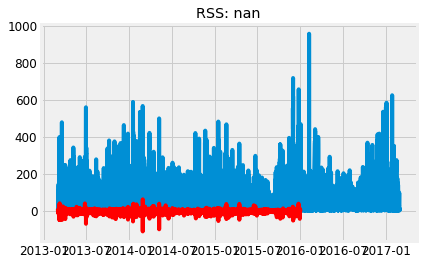

In [ ]:
# ARIMA model
model = ARIMA(train_set["PM2.5"], order=(2, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df["PM2.5"])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df["PM2.5"])**2))

## Prophet

In [ ]:
# https://facebook.github.io/prophet/docs/quick_start.html#python-api
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [ ]:
# format data for prophet model using 'ds' and 'y'
train_prophet = train_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds', 
                        'PM2.5':'y'
                    })

test_prophet = test_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds',
                        'PM2.5':'y'
                    })

In [ ]:
# instantiating the class with custom settings, for the sake of illustration
prophet = Prophet(
     
# fitting the model
prophet.fit(train_prophet)

# part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast_P = prophet.predict(future)

SyntaxError: ignored

In [ ]:
def mape(y_true, y_pred):
    """ Mean Absolute Percentage Error """
    
    # convert to numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # take the percentage error
    pe = (y_true - y_pred) / y_true
    
    # take the absolute values
    ape = np.abs(pe)
    
    # quantify the performance in a single number
    mape = np.mean(ape)
    
    return f'{mape*100:.2f}%'

In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_prophet.ds, y=test_prophet.y,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat,
                         mode='lines', 
                         name='Test - Prediction'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Prophet Forecast of Hourly Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

# quantify accuracy
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

MAPE for Prophet's predictions: 1145.48%


## Holt-Winter

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
holt=Holt(np.asarray(train_set["PM2.5"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [ ]:
y_pred=test_set.copy()
y_pred["Holt"] = holt.forecast(len(test_set))
model_scores=[]
model_scores.append(np.sqrt(mean_squared_error(y_pred["PM2.5"],y_pred["Holt"])))
print("Root Mean Square Error Holt's Linear Model: ",np.sqrt(mean_squared_error(y_pred["PM2.5"],y_pred["Holt"])))

Root Mean Square Error Holt's Linear Model:  67769.77685490959


In [ ]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=train_set.index, y=train_set["PM2.5"],
                    mode='lines+markers',name="Train Data for Confirmed Cases"))
fig.add_trace(go.Scatter(x=test_set.index, y=test_set["PM2.5"],
                    mode='lines+markers',name="Validation Data for Confirmed Cases",))
fig.add_trace(go.Scatter(x=test_set.index, y=y_pred["Holt"],
                    mode='lines+markers',name="Prediction of Confirmed Cases",))
fig.update_layout(title="Confirmed Cases Holt's Linear Model Prediction",
                 xaxis_title="Date",yaxis_title="Confirmed Cases",legend=dict(x=0,y=1,traceorder="normal"))
fig.show()

## Old Holt-Winter

In [ ]:
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
holt=Holt(np.asarray(train_set["PM2.5"])).fit(smoothing_level=0.4, smoothing_slope=0.4,optimized=False)     

In [ ]:
# exponential smoothing only takes into consideration patterns in the target variable
# so we discard the other features
exp_smooth_train, exp_smooth_test = train_set, valid_set

# fit & predict
holt_winter = sm.tsa.ExponentialSmoothing(exp_smooth_train,
                                          seasonal_periods=24*365,
                                          seasonal='add').fit()
y_hat_holt_winter = holt_winter.forecast(len(exp_smooth_test))

In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=exp_smooth_test.index, y=exp_smooth_test,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=y_hat_holt_winter.index, y=y_hat_holt_winter,
                         mode='lines', 
                         name='Test - Prediction'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Holt-Winter Forecast of Hourly Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')

## Auto ARIMA

In [ ]:
#building the model
model = auto_arima(train_set,start_p=0,d=1,start_q=0,max_p=5,max_d=5,max_q=5, trace=True, 
                   error_action='ignore', suppress_warnings=True)
model.fit(train_set)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=220464.246, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=219495.146, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=219427.729, Time=2.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220462.249, Time=0.32 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=219429.430, Time=4.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=219429.330, Time=4.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=46.38 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=219425.730, Time=0.92 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=219427.432, Time=1.69 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=219427.332, Time=1.45 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=219493.148, Time=0.37 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=11.62 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 75.955 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Modeling
# Build Model
model = ARIMA(np.asarray(train_set), order=(2,1,1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                24863
Model:                 ARIMA(2, 1, 1)   Log Likelihood             -109451.506
Method:                       css-mle   S.D. of innovations             19.751
Date:                Tue, 04 May 2021   AIC                         218913.012
Time:                        19:51:00   BIC                         218953.618
Sample:                             1   HQIC                        218926.158
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.004      0.378      0.706      -0.006       0.009
ar.L1.D.y      1.1760      0.006    189.697      0.000       1.164       1.188
ar.L2.D.y     -0.2154      0.006    -34.745      0.0

In [ ]:
# Forecast
fc, se, conf = fitted.forecast(10200, alpha=0.05)  # 95% conf

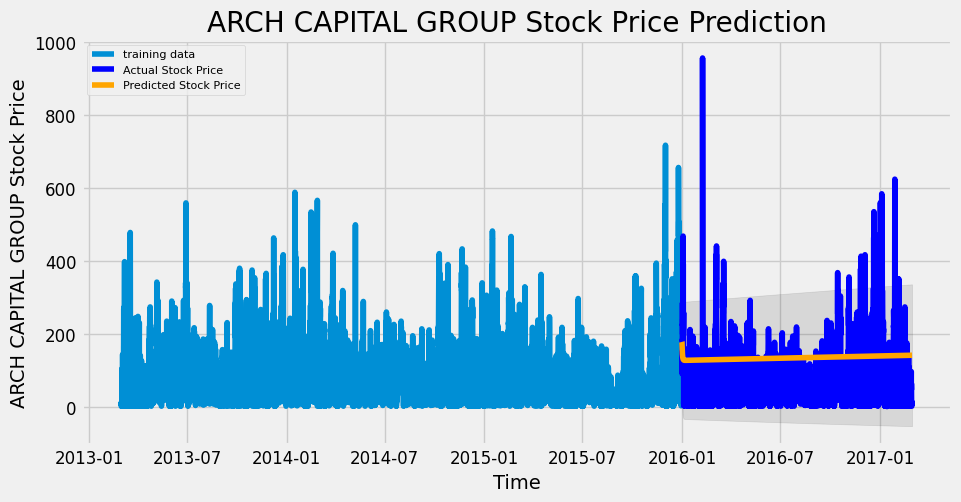

In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_set.index)
lower_series = pd.Series(conf[:, 0], index=test_set.index)
upper_series = pd.Series(conf[:, 1], index=test_set.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_set, label='training data')
plt.plot(test_set, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

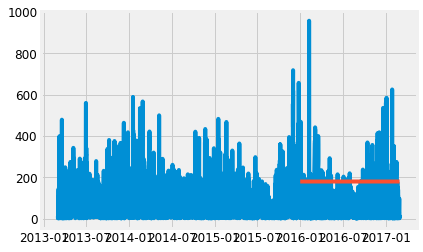

In [ ]:
forecast = model.predict(n_periods=len(test_set))
forecast = pd.DataFrame(forecast,index = test_set.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(df["PM2.5"], label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

## Autoregressive Integrated Moving Average (ARIMA)


In this case,
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1

So p=2, d=1, q=1

In [ ]:
# format data for prophet model using 'ds' and 'y'
train_arima = train_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds', 
                        'PM2.5':'y'
                    })

test_arima = test_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds',
                        'PM2.5':'y'
                    })

In [ ]:
# ARIMA model
arima = ARIMA(np.asarray(train_set), order=(2, 1, 1))

# fitting the model
arima.fit(disp=1);

In [ ]:
# part of the dataframe on which we want to make predictions
future = test_set.index

# predicting values
forecast = arima.predict(future)

In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_set.index, y=test_set,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=test_set.index, y=forecast,
                         mode='lines', 
                         name='Test - Prediction'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='ARIMA Forecast of Hourly PM2.5 Emissions',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='PM2.5 (ug/m3)')

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train_set, order=(2, 1, 1))
model_fit = model.fit(disp=1)

In [ ]:
print(df.index)
print(forecast.index)

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00', '2013-03-01 02:00:00', '2013-03-01 03:00:00', '2013-03-01 04:00:00', '2013-03-01 05:00:00', '2013-03-01 06:00:00', '2013-03-01 07:00:00', '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00', '2017-02-28 16:00:00', '2017-02-28 17:00:00', '2017-02-28 18:00:00', '2017-02-28 19:00:00', '2017-02-28 20:00:00', '2017-02-28 21:00:00', '2017-02-28 22:00:00', '2017-02-28 23:00:00'], dtype='datetime64[ns]', length=35064, freq='H')


AttributeError: ignored

# Grid Search for ARIMA Parameters

(2, 0, 1)x(0, 1, 1, 12)

In [ ]:
from itertools import product

# setting initial values and some bounds for them
ps = range(0, 5)
d = range(0, 2)
qs = range(0, 5)

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs)
parameters_list = list(parameters)
len(parameters_list)

50

In [ ]:
from tqdm import tqdm_notebook
def optimizeSARIMA(y, parameters_list):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeARIMA(df["PM2.5"], parameters_list)

ValueError: ignored

In [ ]:
result_table.head()

parameters            aic
0  (1, 1, 3)  307315.007684
1  (2, 1, 2)  307315.402238
2  (1, 1, 4)  307316.550007
3  (2, 1, 4)  307318.938677
4  (1, 1, 2)  307324.200136

 Best model: SARIMAX(1, 1, 3)

 AIC: 307315.008

In [ ]:
# set the parameters that give the lowest AIC
p, d, q = result_table.parameters[0]

best_model=sm.tsa.statespace.ARIMAX(df["PM2.5"], order=(p, d, q)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                35064
Model:               SARIMAX(1, 1, 3)   Log Likelihood             -153652.504
Date:                Tue, 04 May 2021   AIC                         307315.008
Time:                        04:38:40   BIC                         307357.332
Sample:                    03-01-2013   HQIC                        307328.488
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9527      0.001    901.060      0.000       0.951       0.955
ma.L1         -0.7443      0.002   -493.435      0.000      -0.747      -0.741
ma.L2         -0.2358      0.002   -122.486      0.0

In [ ]:
start_index = "2017-03-01 00:00:00"
end_index = "2019-12-31 23:00:00"

pred = best_model.predict(start=start_index, end=end_index)
pred = best_model.append(pred)
pred_ci = pred.conf_int()
ax = df["PM2.5"].plot(label='observed')
plt.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')
plt.legend()
plt.show()

ValueError: ignored

In [ ]:
def plotARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [ ]:
plotARIMA(df, best_model, 3000)

ValueError: ignored

# Grid Search for SARIMA Parameters

- p is most probably 2 since it is the last significant lag on the PACF, after which, most others are not significant.
- d is most probably 1 because we had first differences
- q is most probably 1 as well as seen on the ACF
- P might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- D again equals 1 because we performed seasonal differentiation
- Q is probably 1. The 24-th lag on ACF is significant while the 48-th is not

In [ ]:
from itertools import product

# setting initial values and some bounds for them
ps = range(0, 3)
d = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
D = range(0, 2)
Qs = range(0, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [ ]:
from tqdm import tqdm_notebook
def optimizeSARIMA(y, parameters_list, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table_12 = pd.DataFrame(results)
    result_table_12.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table_12.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table_12

In [ ]:
%%time
warnings.filterwarnings("ignore") 
result_table_12 = optimizeSARIMA(df["PM2.5"], parameters_list, s)


CPU times: user 4min 27s, sys: 2min 25s, total: 6min 52s
Wall time: 4min 9s


In [ ]:
result_table_12.head()

parameters            aic
0  (0, 0, 0, 0, 0, 0)  433527.810063
1  (0, 0, 0, 0, 0, 1)  414786.290221
2  (0, 0, 0, 0, 1, 0)  399533.192873
3  (0, 0, 0, 0, 1, 1)  396818.224898
4  (0, 0, 0, 1, 0, 0)  396166.654227

Best model:  SARIMAX(2, 0, 1)x(0, 1, 1, 12)

AIC: 307178.211

In [ ]:
# set the parameters that give the lowest AIC
p, d, q, P, D, Q = result_table_12.parameters[0]

best_model_12=sm.tsa.statespace.SARIMAX(df["PM2.5"], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model_12.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                35064
Model:                        SARIMAX   Log Likelihood             -216762.905
Date:                Tue, 04 May 2021   AIC                         433527.810
Time:                        17:20:27   BIC                         433536.275
Sample:                    03-01-2013   HQIC                        433530.506
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.371e+04     67.698    202.536      0.000    1.36e+04    1.38e+04
Ljung-Box (L1) (Q):               32998.61   Jarque-Bera (JB):             63748.68
Prob(Q):                              0.00   Pr

In [ ]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

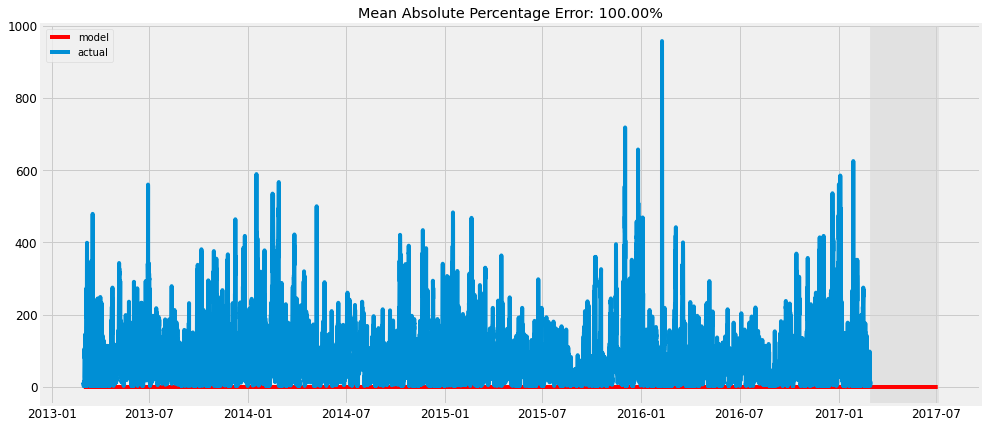

In [ ]:
plotSARIMA(df, best_model_12, 3000)

In [ ]:
start_index = "2017-03-01 00:00:00"
end_index = "2019-12-31 23:00:00"

#Predictions
pred = best_model_12.get_prediction(start=start_index,end=end_index, dynamic=False)

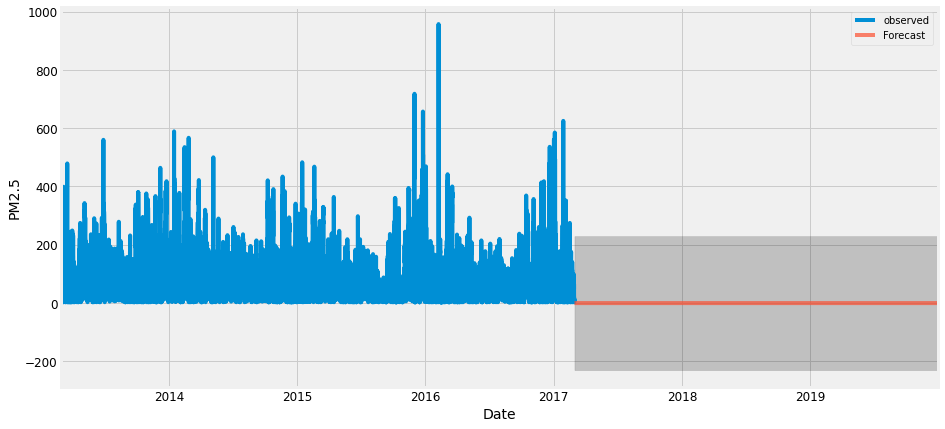

In [ ]:
pred_ci = pred.conf_int()
ax = df["PM2.5"].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('PM2.5')
plt.legend()
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df["PM2.5"], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

# RNN

In [ ]:
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [ ]:
# split into train and test sets(68:32 ratio)
values = df.values
n_train_hours = int(len(values)*0.70)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24544, 1, 0) (24544,) (10520, 1, 0) (10520,)


In [ ]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(32,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],0)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 1, 32)             1056      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 1, 40)             2920      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 40)             0         
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [ ]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
25/25 [==============================] - 3s 9ms/step - loss: 6463.1644
Epoch 2/10
25/25 [==============================] - 0s 8ms/step - loss: 6357.3563
Epoch 3/10
25/25 [==============================] - 0s 8ms/step - loss: 6433.2611
Epoch 4/10
25/25 [==============================] - 0s 8ms/step - loss: 6526.0579
Epoch 5/10
25/25 [==============================] - 0s 9ms/step - loss: 6446.0312
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 6384.1306
Epoch 7/10
25/25 [==============================] - 0s 9ms/step - loss: 6393.7720
Epoch 8/10
25/25 [==============================] - 0s 8ms/step - loss: 6436.9185
Epoch 9/10
25/25 [==============================] - 0s 9ms/step - loss: 6331.8832
Epoch 10/10
25/25 [==============================] - 0s 8ms/step - loss: 6513.3582


In [ ]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)


R2 Score of RNN model =  -0.007163320890913649


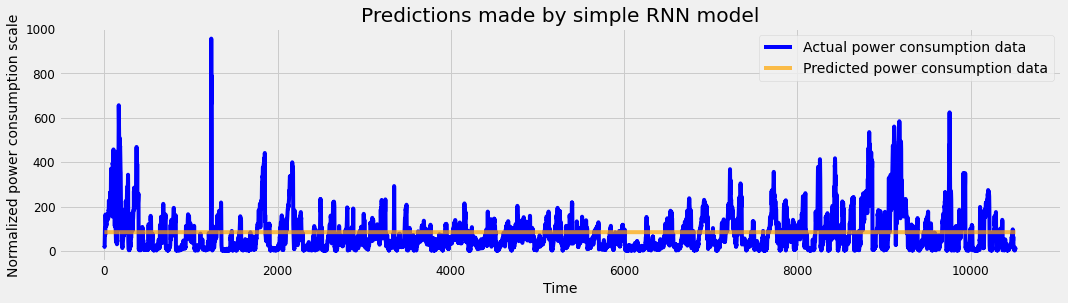

In [ ]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

In [ ]:
lstm_model = Sequential()

lstm_model.add(LSTM(32,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],0)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 32)             4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 40)             11680     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 40)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [ ]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
25/25 [==============================] - 7s 28ms/step - loss: 13839.2634
Epoch 2/10
25/25 [==============================] - 1s 24ms/step - loss: 13776.5980
Epoch 3/10
25/25 [==============================] - 1s 29ms/step - loss: 13395.9004
Epoch 4/10
25/25 [==============================] - 1s 22ms/step - loss: 13648.5437
Epoch 5/10
25/25 [==============================] - 1s 24ms/step - loss: 12687.9585
Epoch 6/10
25/25 [==============================] - 1s 25ms/step - loss: 11909.4346
Epoch 7/10
25/25 [==============================] - 1s 25ms/step - loss: 11831.8502
Epoch 8/10
25/25 [==============================] - 1s 24ms/step - loss: 11580.8013
Epoch 9/10
25/25 [==============================] - 1s 24ms/step - loss: 11350.5017
Epoch 10/10
25/25 [==============================] - 1s 22ms/step - loss: 11185.8529


In [ ]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  -0.48953794631073255


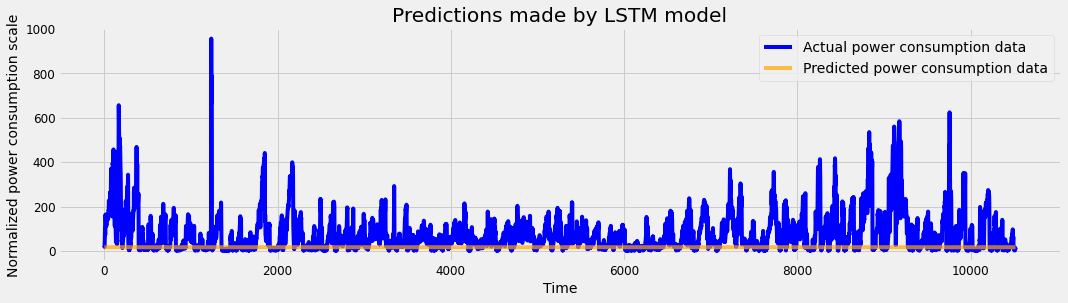

In [ ]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [ ]:
# design network
model = Sequential()
model.add(LSTM(40, input_shape=(X_train.shape[1], X_train.shape[0])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=250, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


Epoch 1/250


ValueError: ignored

In [ ]:
#Train - Test
X_train = train_set.drop("PM2.5", axis=1) 
y_train = train_set["PM2.5"]
X_test = test_set.drop("PM2.5", axis=1)
y_test = test_set["PM2.5"]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
tf.keras.backend.clear_session()

# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_stacked_lstm.fit(train_set, epochs=120,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120


ValueError: ignored

In [ ]:
#XGBoost
import xgboost as xgb

xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=True)

XGBoostError: ignored

In [ ]:
model_A = sm.tsa.statespace.SARIMAX(train_set,
                                order=(2,0,1),
                                seasonal_order=(0,1,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_A = model_A.fit()
print('AIC =', results_A.aic) #AIC
#result_ARIMA = results.forecast(steps=test.shape[0])
forecast_A = results_A.forecast(steps=test_set.shape[0])

AIC = 218635.9029084882


In [ ]:

# account for holidays
prophet.fit(train_prophet);
# part of the dataframe on which we want to make predictions
future_dates = prophet.make_future_dataframe(periods=test_prophet.shape[0], freq='H')

# predicting values
results_P = prophet.predict(future_dates[train_prophet.shape[0]:])
forecast_P = results_P.set_index('ds').yhat

ValueError: ignored

In [ ]:
def to_X(data):
    return pd.Series(data.index).apply(
        lambda x: (x - data.index[0]).components.hours) \
                                .values \
                                .reshape(-1,1)

model_X = xgb.XGBRegressor(n_estimators=30)
model_X.fit(to_X(train_set), train_set.values,
        eval_set=[(to_X(train_set), train_set.values), (to_X(test_set), test_set.values)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

forecast_X = model_X.predict(to_X(test_set))

[19:07:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


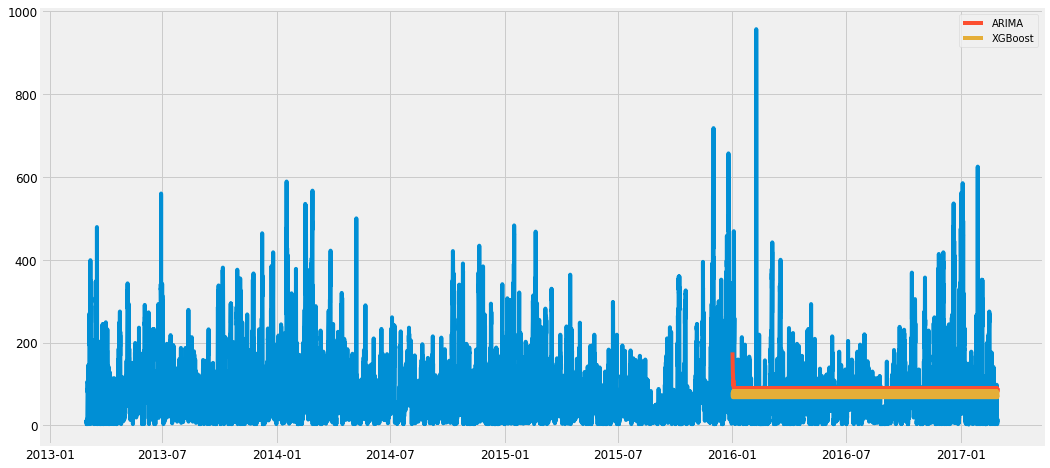

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(pd.concat([train_set,test_set]))
plt.plot(test_set.index, forecast_A, label='ARIMA')
plt.plot(test_set.index, forecast_X, label='XGBoost')
plt.legend()